In [1]:
import os
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.formula.api import ols, mixedlm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import bartlett, kruskal

%matplotlib inline

In [2]:
def load_data(path):
    df = pd.read_csv(path)
    g = df.groupby(['network_size', 'network', 'simulation'])
    df['it2'] = g.cumcount()
    df.sort_values(['network_size', 'network', 'simulation', 'it'], inplace=True)
    for c in df.columns:
        if c.endswith('_avar') or (c.endswith('_mean') and c not in ('GG_mean', 'CL_mean')):
            del df[c]
    return df

In [3]:
env_shift = load_data('ext_env_shift_results_vi.csv')
top_shift = load_data('ext_top_shift_results_vi.csv')

In [4]:
all_data = pd.concat({
        'env_shift': env_shift,
        'top_shift': top_shift
    }, names=['paradigm']).reset_index('paradigm')
all_data.to_csv('all_data.csv')

In [5]:
def load_old(ddir, rexpr):
    dfs = {}
    for fn in os.listdir(ddir):
        path = os.path.join(ddir, fn)
        if not os.path.isfile(path):
            continue
        if 'ccw' in fn: # fck u
            fn = fn.replace('ccw', 'CCW')
        m = re.match(rexpr, fn)
        if not m:
            print(path)
            continue
        #print(m.groups())
        isim = int(m.group('simulation'))
        meas = m.group('measure')
        if meas == 'CSA':
            meas = 'GG_mean'
        elif meas == 'CLA':
            meas = 'CL_mean'
        else:
            continue
        netname = m.group('network')
        key = (netname, isim)
        if netname not in ('max_avg_bet', 'min_avg_bet', 'hub', 'hub_speaker', 'hub_hearer', 'clique'):
            continue
        X = pd.read_table(path, header=None)
        X.set_index(0, inplace=True)
        vals = X.mean(axis=1)      
        if key in dfs:
            df = dfs[key]
            df[meas] = vals
        else:
            df = pd.DataFrame({meas: vals})
            df['simulation'] = isim
            df['network'] = netname
            dfs[key] = df

    alldf = pd.concat(dfs)
    alldf['network_size'] = 16
    alldf.reset_index(inplace=True)
    alldf.rename(columns={0: 'it'}, inplace=True)
    del alldf['level_0']
    alldf['it2'] = alldf['it'] // 50
    return alldf

In [6]:
ts16 = load_old('raw_data_N16/shift_sim_data/', r'^data_(?P<network>\w+)_to_clique_(?P<measure>\w+)(?P<simulation>\d)$')
es16 = load_old('raw_data_N16/env_shift_gauss_sim_data/', r'^data_env_training(?P<network>[a-z_]+)(?P<measure>[A-Z_]+)_(?P<simulation>\d)$')

env_shift = pd.concat([env_shift, es16])
top_shift = pd.concat([top_shift, ts16])

env_shift.sort_values(['network_size', 'network', 'simulation', 'it'], inplace=True)
top_shift.sort_values(['network_size', 'network', 'simulation', 'it'], inplace=True)

In [7]:
es16.network.value_counts()

min_avg_bet    4010
hub_speaker    4010
hub            4010
max_avg_bet    4010
hub_hearer     4010
clique         4010
Name: network, dtype: int64

In [8]:
env_shift[:5]

,CL_mean,GG_mean,it,it2,level_1,network,network_size,simulation
0,0.000000,0.000000,0,0,NaN,clique,8,0
1,0.000000,0.000000,25,1,NaN,clique,8,0
2,0.000000,0.016146,50,2,NaN,clique,8,0
3,0.023838,0.050867,75,3,NaN,clique,8,0
4,0.052626,0.095114,100,4,NaN,clique,8,0


  * GG -- to jest communicative success dla pierwszej topologii/środowiska, na której uczymy najpierw.
  * CL -- to jest communicative success dla drugiej topologii/środowiska.
  
  
  * DG -- to jest discriminative success dla pierwszej topologii/środowiska.  
  * DG_CL -- to jest discriminative success dla drugiej topologii/środowiska.

In [9]:
phase1 = 100
phase2 = 200
cols = ['network', 'network_size']

In [10]:
plt.rcParams['figure.figsize']=(12,6)

In [11]:
def do_anal(df, dv, alpha=0.05):
    sizes = sorted(set(df['network_size']))
    networks = sorted(set(df['network']))
    #print([n for n in sizes])
    #print([net for net in networks])
    sns.boxplot(data=df, y=dv, x='network_size', hue='network')
    tab = []
    for N in sizes:
        dfn = df[df.network_size == N]
        print("SIZE = %d" % N)        
        grp = [dfn[dfn.network == net][dv] for net in networks]
        T, p = bartlett(*grp)
        print("Bartlett: T=%f, p=%f" % (T, p))
        #H, p = kruskal(*grp)
        #print("Kruskal-Wallis: H=%f, p=%f" % (H, p))
        # mm = mixedlm(dv + ' ~ network', df, groups=df['network_size']).fit()        
        mm = ols(dv + ' ~ network', dfn).fit()
        print("ANOVA: F(%d,%d)=%f, p=%f, " % (mm.df_model, mm.df_resid, mm.fvalue, mm.f_pvalue))
        # print(mm.summary())
        mcomp = pairwise_tukeyhsd(endog=dfn[dv], groups=dfn['network'], alpha=alpha)
        # mcomp.plot_simultaneous()
        # print(mcomp.summary())
        tab.append('%d & %.1f & %.3f \\\\' % (N, mm.fvalue, mm.f_pvalue))
    for row in tab:
        print(row)

## After first pahse iterations (=10k for 16)

In [12]:
df = top_shift
p1_CSL = df[df.it2==phase1][cols + ['GG_mean']]
p1_CSG = df[df.it2==phase1][cols + ['CL_mean']]

SIZE = 8
Bartlett: T=1.922747, p=0.859728
ANOVA: F(5,54)=6.013149, p=0.000171, 
SIZE = 12
Bartlett: T=4.796518, p=0.441215
ANOVA: F(5,54)=17.594484, p=0.000000, 
SIZE = 16
Bartlett: T=2.869259, p=0.720134
ANOVA: F(5,54)=26.103605, p=0.000000, 
SIZE = 24
Bartlett: T=16.319246, p=0.005989
ANOVA: F(5,54)=56.435042, p=0.000000, 
SIZE = 32
Bartlett: T=10.234887, p=0.068847
ANOVA: F(5,54)=170.034540, p=0.000000, 
SIZE = 48
Bartlett: T=29.175596, p=0.000021
ANOVA: F(5,54)=172.476153, p=0.000000, 
8 & 6.0 & 0.000 \\
12 & 17.6 & 0.000 \\
16 & 26.1 & 0.000 \\
24 & 56.4 & 0.000 \\
32 & 170.0 & 0.000 \\
48 & 172.5 & 0.000 \\


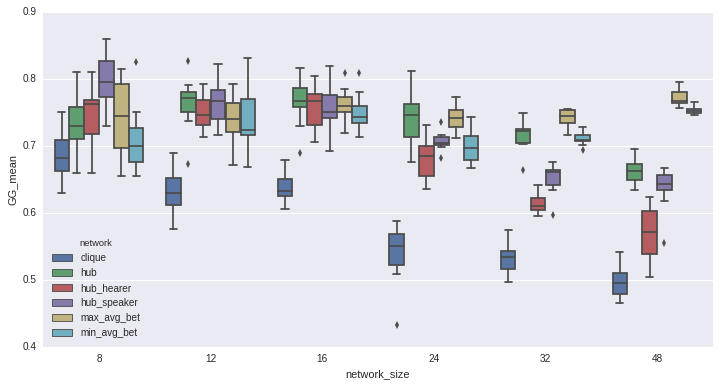

In [13]:
mm = do_anal(p1_CSL, 'GG_mean')

SIZE = 8
Bartlett: T=7.038594, p=0.217786
ANOVA: F(5,54)=24.238422, p=0.000000, 
SIZE = 12
Bartlett: T=5.229595, p=0.388508
ANOVA: F(5,54)=83.627944, p=0.000000, 
SIZE = 16
Bartlett: T=8.067367, p=0.152562
ANOVA: F(5,54)=187.370858, p=0.000000, 
SIZE = 24
Bartlett: T=11.846487, p=0.036953
ANOVA: F(5,54)=486.721605, p=0.000000, 
SIZE = 32
Bartlett: T=23.903454, p=0.000227
ANOVA: F(5,54)=551.192129, p=0.000000, 
SIZE = 48
Bartlett: T=50.921590, p=0.000000
ANOVA: F(5,54)=686.335319, p=0.000000, 
8 & 24.2 & 0.000 \\
12 & 83.6 & 0.000 \\
16 & 187.4 & 0.000 \\
24 & 486.7 & 0.000 \\
32 & 551.2 & 0.000 \\
48 & 686.3 & 0.000 \\


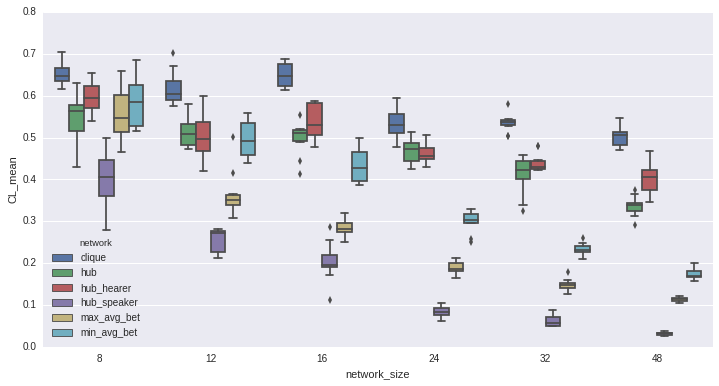

In [14]:
do_anal(p1_CSG, 'CL_mean')

## Topology shift

In [15]:
df = top_shift
ts_CSL = df[df.it2==phase2][cols + ['GG_mean']]
ts_CSG = df[df.it2==phase2][cols + ['CL_mean']]

SIZE = 8
Bartlett: T=8.879549, p=0.113966
ANOVA: F(5,54)=2.179520, p=0.069888, 
SIZE = 12
Bartlett: T=5.355264, p=0.374078
ANOVA: F(5,54)=9.836895, p=0.000001, 
SIZE = 16
Bartlett: T=6.700877, p=0.243854
ANOVA: F(5,54)=16.802312, p=0.000000, 
SIZE = 24
Bartlett: T=18.534867, p=0.002346
ANOVA: F(5,54)=54.347821, p=0.000000, 
SIZE = 32
Bartlett: T=22.543946, p=0.000413
ANOVA: F(5,54)=80.546180, p=0.000000, 
SIZE = 48
Bartlett: T=24.716047, p=0.000158
ANOVA: F(5,54)=376.936524, p=0.000000, 
8 & 2.2 & 0.070 \\
12 & 9.8 & 0.000 \\
16 & 16.8 & 0.000 \\
24 & 54.3 & 0.000 \\
32 & 80.5 & 0.000 \\
48 & 376.9 & 0.000 \\


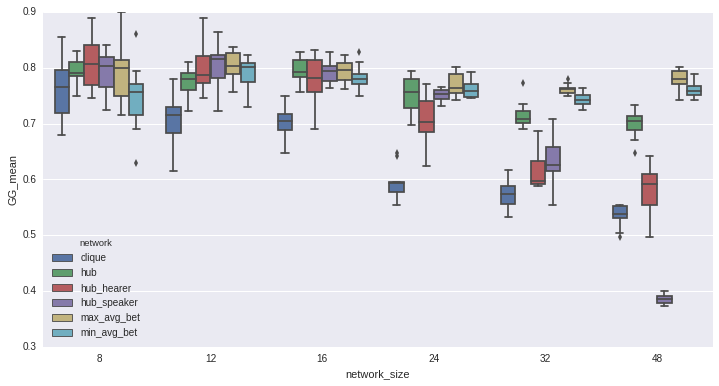

In [16]:
do_anal(ts_CSL, 'GG_mean')

SIZE = 8
Bartlett: T=12.975077, p=0.023613
ANOVA: F(5,54)=30.056237, p=0.000000, 
SIZE = 12
Bartlett: T=9.719409, p=0.083587
ANOVA: F(5,54)=108.123832, p=0.000000, 
SIZE = 16
Bartlett: T=13.833080, p=0.016705
ANOVA: F(5,54)=248.332066, p=0.000000, 
SIZE = 24
Bartlett: T=10.269032, p=0.067961
ANOVA: F(5,54)=526.634748, p=0.000000, 
SIZE = 32
Bartlett: T=10.314535, p=0.066798
ANOVA: F(5,54)=940.158145, p=0.000000, 
SIZE = 48
Bartlett: T=61.404808, p=0.000000
ANOVA: F(5,54)=511.702101, p=0.000000, 
8 & 30.1 & 0.000 \\
12 & 108.1 & 0.000 \\
16 & 248.3 & 0.000 \\
24 & 526.6 & 0.000 \\
32 & 940.2 & 0.000 \\
48 & 511.7 & 0.000 \\


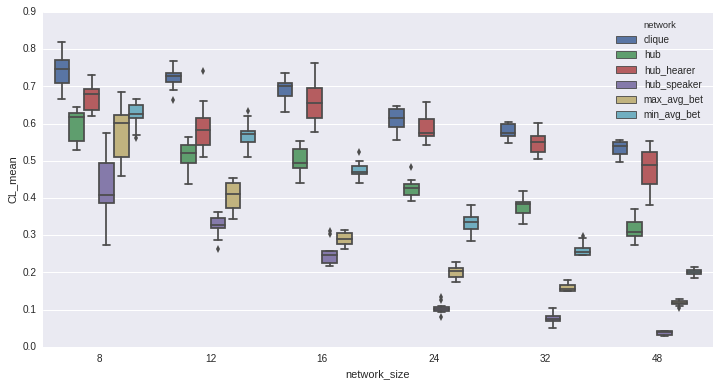

In [17]:
do_anal(ts_CSG, 'CL_mean')

## Environment shift

In [18]:
df = env_shift
es_CSL = df[df.it2==phase2][cols + ['GG_mean']]
es_CSG = df[df.it2==phase2][cols + ['CL_mean']]

SIZE = 8
Bartlett: T=8.879549, p=0.113966
ANOVA: F(5,54)=2.179520, p=0.069888, 
SIZE = 12
Bartlett: T=5.355264, p=0.374078
ANOVA: F(5,54)=9.836895, p=0.000001, 
SIZE = 16
Bartlett: T=6.700877, p=0.243854
ANOVA: F(5,54)=16.802312, p=0.000000, 
SIZE = 24
Bartlett: T=18.534867, p=0.002346
ANOVA: F(5,54)=54.347821, p=0.000000, 
SIZE = 32
Bartlett: T=22.543946, p=0.000413
ANOVA: F(5,54)=80.546180, p=0.000000, 
SIZE = 48
Bartlett: T=24.716047, p=0.000158
ANOVA: F(5,54)=376.936524, p=0.000000, 
8 & 2.2 & 0.070 \\
12 & 9.8 & 0.000 \\
16 & 16.8 & 0.000 \\
24 & 54.3 & 0.000 \\
32 & 80.5 & 0.000 \\
48 & 376.9 & 0.000 \\


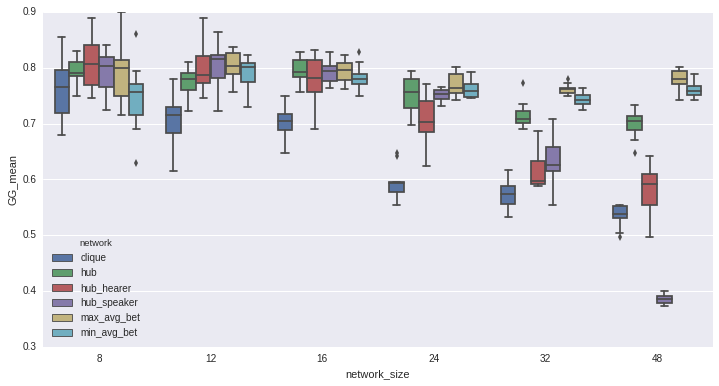

In [19]:
do_anal(ts_CSL, 'GG_mean')

SIZE = 8
Bartlett: T=12.975077, p=0.023613
ANOVA: F(5,54)=30.056237, p=0.000000, 
SIZE = 12
Bartlett: T=9.719409, p=0.083587
ANOVA: F(5,54)=108.123832, p=0.000000, 
SIZE = 16
Bartlett: T=13.833080, p=0.016705
ANOVA: F(5,54)=248.332066, p=0.000000, 
SIZE = 24
Bartlett: T=10.269032, p=0.067961
ANOVA: F(5,54)=526.634748, p=0.000000, 
SIZE = 32
Bartlett: T=10.314535, p=0.066798
ANOVA: F(5,54)=940.158145, p=0.000000, 
SIZE = 48
Bartlett: T=61.404808, p=0.000000
ANOVA: F(5,54)=511.702101, p=0.000000, 
8 & 30.1 & 0.000 \\
12 & 108.1 & 0.000 \\
16 & 248.3 & 0.000 \\
24 & 526.6 & 0.000 \\
32 & 940.2 & 0.000 \\
48 & 511.7 & 0.000 \\


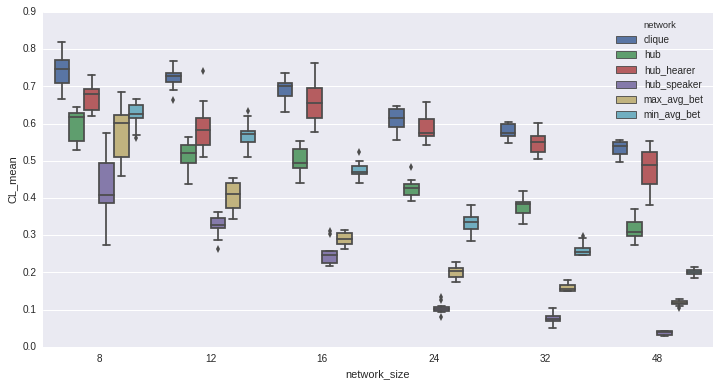

In [20]:
do_anal(ts_CSG, 'CL_mean')